In [2]:
!pip install torchaudio librosa pandas --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00:00:0100:01


# Preprocessing and Data Loading

In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn import metrics
import matplotlib.pyplot as plt

2025-08-19 08:39:01.818341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755592742.174730      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755592742.290119      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# ================== IMPORTS ==================


# Constants
SAMPLE_RATE = 16000
N_MELS = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================== SSL MODEL LOADING ==================
ssl_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
ssl_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device).eval()

# ================== PROTOCOL LOADING ==================
# ================== Unified Dataset Loader ==================
def load_dataset(dataset_name, split="train", batch_size=16, augment=True):
    """
    Unified loader for ASVspoof 2017, ASVspoof 2019, and ReMASC.
    Args:
        dataset_name (str): "2017", "2019", or "remasc"
        split (str): "train", "dev", or "eval"
        batch_size (int)
        augment (bool): Apply augmentation (training only)
    Returns:
        DataLoader
    """
    if dataset_name == "2019":
        # Paths for 2019
        if split == "train":
            audio_base = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
            protocol_file = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
        elif split == "dev":
            audio_base = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
            protocol_file = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
        else:
            audio_base = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac"
            protocol_file = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
        
        df = pd.read_csv(protocol_file, sep=' ', header=None)
        df.columns = ['speaker_id', 'file_id', 'system_id', 'attack_id', 'key']
        df['label'] = df['key'].apply(lambda x: 1 if x == 'bonafide' else 0)
        if dataset_name == "2019":
            ext = "flac"
        elif dataset_name == "2017":
            ext = "wav"
        else:
            ext = "wav"  # default for others like ReMASC
        
        df['file_path'] = df['file_id'].apply(lambda x: os.path.join(audio_base, f"{x}.{ext}"))

    elif dataset_name == "2017":
        # Paths for 2017
        if split == "train":
            audio_base = "/kaggle/input/asvspoof2017/ASVspoof2017_V2_train/ASVspoof2017_V2_train"
            protocol_file = "/kaggle/input/asvspoof2017/protocol_V2/protocol_V2/ASVspoof2017_V2_train.trn.txt"
        else:
            audio_base = "/kaggle/input/asvspoof2017/ASVspoof2017_V2_dev/ASVspoof2017_V2_dev"
            protocol_file = "/kaggle/input/asvspoof2017/protocol_V2/protocol_V2/ASVspoof2017_V2_dev.trl.txt"
        
        df_raw = pd.read_csv(protocol_file, sep=' ', header=None)
        if df_raw.shape[1] == 3:
            df_raw.columns = ['speaker_id', 'file_id', 'key']
            df_raw['label'] = df_raw['key'].apply(lambda x: 1 if str(x).lower() == 'bonafide' else 0)
        elif df_raw.shape[1] == 7:
            df_raw.columns = ['file_id', 'source', 'channel', 'codec', 'attack_type', 'key1', 'key2']
            df_raw['label'] = df_raw['source'].apply(lambda x: 1 if str(x).lower() == 'genuine' else 0)
        else:
            raise ValueError(f"Unexpected column count ({df_raw.shape[1]}) in 2017 protocol")
    
        df_raw['file_path'] = df_raw['file_id'].apply(lambda x: os.path.join(audio_base, x))

        # Filter only those files that physically exist
        df_raw = df_raw[df_raw['file_path'].apply(os.path.exists)]
        
        df = df_raw

    elif dataset_name == "remasc":
        # Placeholder paths (update based on actual ReMASC dataset)
        if split == "train":
            raise ValueError("ReMASC is for validation/testing only.")
        audio_base = "/kaggle/input/remasc/flac"
        protocol_file = "/kaggle/input/remasc/protocol.txt"
        df = pd.read_csv(protocol_file, sep=' ', header=None)
        df.columns = ['file_id', 'key']
        df['label'] = df['key'].apply(lambda x: 1 if str(x).lower() == 'bonafide' else 0)
        df['file_path'] = df['file_id'].apply(lambda x: os.path.join(audio_base, f"{x}.wav"))

    else:
        raise ValueError("Unsupported dataset name. Use '2017', '2019', or 'remasc'.")

    # Create dataset and dataloader
    dataset = ASVspoofMultiModalDataset(df, ssl_processor, ssl_model, augment=(augment and split=="train"))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=(split=="train"),
                        collate_fn=lambda batch: multimodal_collate_fn(batch, apply_augment=(split=="train")))
    
    return loader

# ================== AUDIO HELPERS ==================
def load_audio(path):
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != SAMPLE_RATE:
        resample = T.Resample(orig_freq=sample_rate, new_freq=SAMPLE_RATE)
        waveform = resample(waveform)
    return waveform

def extract_logmel(waveform, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
    mel_spec = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=400,
        win_length=400,
        hop_length=160,
        n_mels=n_mels
    )(waveform)
    logmel = torch.log(mel_spec + 1e-6)
    return logmel

def apply_spec_augment(spec, num_time_masks=1, num_freq_masks=1, max_time_mask=30, max_freq_mask=8):
    """
    Applies SpecAugment to a spectrogram tensor.
    Args:
        spec: Tensor [n_mels, time]
    """
    augmented_spec = spec.clone()

    # Frequency masking
    for _ in range(num_freq_masks):
        freq_mask_size = random.randint(0, max_freq_mask)
        freq_mask_start = random.randint(0, max(0, spec.shape[0] - freq_mask_size))
        augmented_spec[freq_mask_start:freq_mask_start + freq_mask_size, :] = 0

    # Time masking
    for _ in range(num_time_masks):
        time_mask_size = random.randint(0, max_time_mask)
        time_mask_start = random.randint(0, max(0, spec.shape[1] - time_mask_size))
        augmented_spec[:, time_mask_start:time_mask_start + time_mask_size] = 0

    return augmented_spec

def multimodal_collate_fn(batch, apply_augment=True):
    ssl_features = torch.stack([item["ssl"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])

    # Handle variable-length spectrograms
    spectrograms = [item["spectrogram"] for item in batch]
    max_len = max([spec.shape[1] for spec in spectrograms])  # longest time dimension
    padded_specs = []
    
    for spec in spectrograms:
        pad_len = max_len - spec.shape[1]
        if pad_len > 0:
            spec = F.pad(spec, (0, pad_len))  # pad time dimension
        if apply_augment:
            spec = apply_spec_augment(spec)
        padded_specs.append(spec)
    
    spectrograms = torch.stack(padded_specs)

    return {"ssl": ssl_features, "spectrogram": spectrograms, "label": labels}

# ================== DATASET CLASS ==================
class ASVspoofMultiModalDataset(Dataset):
    def __init__(self, df, ssl_processor, ssl_model, augment=False):
        self.df = df
        self.ssl_processor = ssl_processor
        self.ssl_model = ssl_model
        self.augment = augment

    def _augment_audio(self, waveform):
        if random.random() < 0.3:
            noise = torch.randn_like(waveform) * 0.005
            waveform += noise
        return waveform

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        waveform = load_audio(row['file_path'])

        if self.augment:
            waveform = self._augment_audio(waveform)

        # ========== Spectrogram Features ==========
        logmel = extract_logmel(waveform)

        # ========== SSL Embeddings ==========
        inputs = self.ssl_processor(waveform.squeeze().numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt").to(device)
        with torch.no_grad():
            ssl_features = self.ssl_model(**inputs).last_hidden_state.mean(dim=1)

        return {
            "ssl": ssl_features.squeeze(0).cpu(),  # [768]
            "spectrogram": logmel.squeeze(0),       # [64, Time]
            "label": torch.tensor(row['label']).long()
        }

    def __len__(self):
        return len(self.df)




Using device: cuda


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [5]:
# Load ASVspoof 2019 train/dev
train_loader_2019 = load_dataset("2019", split="train", batch_size=16)
dev_loader_2019 = load_dataset("2019", split="dev", batch_size=16)

# Load ASVspoof 2017 train/dev
train_loader_2017 = load_dataset("2017", split="train", batch_size=16)
dev_loader_2017 = load_dataset("2017", split="dev", batch_size=16)

# Load ReMASC (only dev/test)
# dev_loader_remasc = load_dataset("remasc", split="dev", batch_size=16, augment=False)



In [6]:
df_raw = pd.read_csv("/kaggle/input/asvspoof2017/protocol_V2/protocol_V2/ASVspoof2017_V2_dev.trl.txt", sep=' ', header=None)

# Check the first few rows
print(df_raw.head())

# Check unique values in the column that should be 'bonafide' or 'spoof'
print("Unique values in key column:", df_raw.iloc[:, -1].unique())


               0        1      2    3  4  5  6
0  D_1000001.wav  genuine  M0011  S06  -  -  -
1  D_1000002.wav  genuine  M0011  S08  -  -  -
2  D_1000003.wav  genuine  M0011  S04  -  -  -
3  D_1000004.wav  genuine  M0011  S07  -  -  -
4  D_1000005.wav  genuine  M0011  S10  -  -  -
Unique values in key column: ['-' 'R06' 'R05' 'R07' 'R03' 'R02' 'R01' 'R04']


# Training

In [7]:
# ================== MODEL ==================
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=1, feature_dim=256):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128 * 16, feature_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.adaptive_avg_pool2d(x, (16, 1)).flatten(1)
        return self.fc(x)

class TransformerFusionModel(nn.Module):
    def __init__(self, ssl_dim=768, feature_dim=256, num_heads=4, num_layers=2, num_classes=2):
        super(TransformerFusionModel, self).__init__()
        self.ssl_proj = nn.Linear(ssl_dim, feature_dim)
        self.spec_encoder = CNNEncoder(1, feature_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=num_heads, dim_feedforward=512, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(feature_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)
    def forward(self, ssl, spec):
        ssl_emb = self.ssl_proj(ssl).unsqueeze(1)
        spec_emb = self.spec_encoder(spec).unsqueeze(1)
        seq = torch.cat([ssl_emb, spec_emb], dim=1)
        fused = self.transformer(seq)[:, 0, :]
        x = self.dropout(F.relu(self.fc1(fused)))
        return self.fc2(x)


class TransformerFusionModel_DANN(nn.Module):
    def __init__(self):
        super(TransformerFusionModel_DANN, self).__init__()
        
        self.ssl_proj = nn.Linear(768, 256)
        
        self.spec_encoder = CNNEncoder()
        # self.transformer = TransformerEncoder()
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: bonafide vs spoof

        # Domain classifier for DANN
        self.domain_classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # domain: source vs target
        )

    def forward(self, ssl, spec, alpha=None):
        ssl_feat = self.ssl_proj(ssl)  # [B, 256]
        spec_feat = self.spec_encoder(spec)  # [B, 256]

        fused = ssl_feat + spec_feat  # simple fusion

        if self.training and alpha is not None:
            reverse_feat = grad_reverse(fused, alpha)
            domain_out = self.domain_classifier(reverse_feat)
            class_out = self.fc2(F.relu(self.fc1(fused)))
            return class_out, domain_out
        else:
            class_out = self.fc2(F.relu(self.fc1(fused)))
            return class_out


# ================== DANN MODEL ==================
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class DomainAdversarialModel(TransformerFusionModel):
    def __init__(self, ssl_dim=768, feature_dim=256, num_heads=4, num_layers=2, num_classes=2, lambda_grl=0.1):
        super(DomainAdversarialModel, self).__init__(ssl_dim, feature_dim, num_heads, num_layers, num_classes)
        self.lambda_grl = lambda_grl
        self.domain_classifier = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    def forward(self, ssl, spec, alpha=1.0):
        ssl_emb = self.ssl_proj(ssl).unsqueeze(1)
        spec_emb = self.spec_encoder(spec).unsqueeze(1)
        seq = torch.cat([ssl_emb, spec_emb], dim=1)
        fused = self.transformer(seq)[:, 0, :]
        x = self.dropout(F.relu(self.fc1(fused)))
        class_output = self.fc2(x)
        reverse_feature = GradientReversalLayer.apply(fused, alpha * self.lambda_grl)
        domain_output = self.domain_classifier(reverse_feature)
        return class_output, domain_output

    

# ================== METRICS ==================
def compute_eer(y_true, y_scores):
    if np.sum(y_true) == 0 or np.sum(y_true) == len(y_true):
        print("Warning: y_true contains only one class. Skipping EER computation.")
        return np.nan

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return eer * 100

def compute_tDCF(y_true, y_scores):
    eer = compute_eer(y_true, y_scores)
    return eer * 0.01

# ================== TRAINING ==================
def train_model_switch(mode="normal", epochs=10, lr=1e-4, save_path="model.pth"):
    if mode == "dann":
        model = DomainAdversarialModel().to(device)
    else:
        model = TransformerFusionModel().to(device)
    criterion_class = nn.CrossEntropyLoss()
    criterion_domain = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    train_loader_src = load_dataset("2019", "train")
    val_loader = load_dataset("2019", "dev", augment=False)
    
    if mode == "dann":
        train_loader_tgt = load_dataset("2017", "train")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        if mode == "dann":
            for (src_batch, tgt_batch) in zip(train_loader_src, train_loader_tgt):
                ssl_src, spec_src, labels_src = src_batch["ssl"].to(device), src_batch["spectrogram"].to(device), src_batch["label"].to(device)
                ssl_tgt, spec_tgt = tgt_batch["ssl"].to(device), tgt_batch["spectrogram"].to(device)
                domain_src = torch.zeros(ssl_src.size(0), dtype=torch.long).to(device)
                domain_tgt = torch.ones(ssl_tgt.size(0), dtype=torch.long).to(device)
                optimizer.zero_grad()
                class_out_src, domain_out_src = model(ssl_src, spec_src)
                _, domain_out_tgt = model(ssl_tgt, spec_tgt)
                loss_class = criterion_class(class_out_src, labels_src)
                loss_domain = criterion_domain(domain_out_src, domain_src) + criterion_domain(domain_out_tgt, domain_tgt)
                loss = loss_class + loss_domain
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        else:
            for batch in train_loader_src:
                ssl, spec, labels = batch["ssl"].to(device), batch["spectrogram"].to(device), batch["label"].to(device)
                optimizer.zero_grad()
                outputs = model(ssl, spec)
                loss = criterion_class(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader_src)
        eer, _ = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | EER: {eer:.2f}%")
    
    torch.save(model.state_dict(), save_path)
    print("✅ Model saved:", save_path)
    return model

def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            ssl = batch["ssl"].to(device)
            spec = batch["spectrogram"].to(device)
            labels = batch["label"].to(device)
            logits = model(ssl, spec)
            probs = torch.softmax(logits, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    eer = compute_eer(np.array(all_labels), np.array(all_probs))
    tdcf = compute_tDCF(np.array(all_labels), np.array(all_probs)) if not np.isnan(eer) else np.nan
    return eer, tdcf

# Model A

In [ ]:
model_A = train_model_switch(mode="normal", save_path="model_2019.pth")

Loading model A logics from local disk after training and downloading the model

In [14]:
model_A = TransformerFusionModel()
model_A.load_state_dict(torch.load("/kaggle/input/modela-voicespoofing/model_2019.pth"))
model_A.to(device).eval()

TransformerFusionModel(
  (ssl_proj): Linear(in_features=768, out_features=256, bias=True)
  (spec_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=2048, out_features=256, bias=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, o

Training model B

In [ ]:
model_B = train_model_switch(mode="dann", save_path="model_dann.pth")


Model A evaluation

In [ ]:
test_loader_2017 = load_dataset("2017", "dev", augment=False)
eer, tdcf = evaluate_model(model_A, test_loader_2017)
print(f"Cross-Domain (2017) → EER: {eer:.2f}% | t-DCF: {tdcf:.4f}")


Model B evaluation

In [15]:
model_B = DomainAdversarialModel().to(device)
model_B.load_state_dict(torch.load("/kaggle/input/modelb-voicespoofing/model_dann_2017.pth"))
model_B.eval()

DomainAdversarialModel(
  (ssl_proj): Linear(in_features=768, out_features=256, bias=True)
  (spec_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=2048, out_features=256, bias=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, o

In [ ]:
test_loader_2017 = load_dataset("2017", "dev", augment=False)

# Inference only gives class output
all_labels, all_probs = [], []

with torch.no_grad():
    for batch in test_loader_2017:
        ssl = batch["ssl"].to(device)
        spec = batch["spectrogram"].to(device)
        labels = batch["label"].to(device)
        
        logits, _ = model_B(ssl, spec, alpha=0.0)  # disable GRL during inference
        probs = torch.softmax(logits, dim=1)[:, 1]
        
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

eer = compute_eer(np.array(all_labels), np.array(all_probs))
tdcf = compute_tDCF(np.array(all_labels), np.array(all_probs))

print(f"Model B Evaluation (ASVspoof2017 dev): EER = {eer:.2f}% | t-DCF = {tdcf:.4f}")


## cGAN

In [24]:
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, save_path="best_model.pth"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    best_eer = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            ssl = batch["ssl"].to(device)
            spec = batch["spectrogram"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(ssl, spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_eer, val_tdcf = evaluate_model(model, val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Val EER: {val_eer:.2f}% | Val t-DCF: {val_tdcf:.4f}")

        # Save best model
        if val_eer < best_eer:
            best_eer = val_eer
            torch.save(model.state_dict(), save_path)
            print("✅ Saved best model")

        scheduler.step()


In [25]:
def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            ssl = batch["ssl"].to(device)
            spec = batch["spectrogram"].to(device)
            labels = batch["label"].to(device)

            outputs = model(ssl, spec)
            probs = F.softmax(outputs, dim=1)[:, 1]  # spoof probability

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    eer = compute_eer(np.array(all_labels), np.array(all_probs))
    tdcf = compute_tDCF(np.array(all_labels), np.array(all_probs))
    return eer, tdcf


In [28]:
# ==========================
# (Optional) Low-compute GAN strategy — filter, small injection, perturbation, staged training
# ==========================

# ---- Cell A: Filter synthetics by discriminator quality (top-k) ----
@torch.no_grad()
def select_topk_synthetics(generator, discriminator, pool=5000, keep_top_p=30, device='cuda'):
    generator.eval(); discriminator.eval()
    # Generate a pool, score by D (higher => more real), keep top p-percent
    fake_pool = generate_synthetic_spoofs(generator, num_samples=pool, device=device).to(device)
    d_scores = discriminator(fake_pool).detach().cpu().numpy()
    thresh = np.percentile(d_scores, 100 - keep_top_p)
    idx = np.where(d_scores >= thresh)[0]
    return fake_pool.detach().cpu()[idx]

# Example usage (replace earlier NUM_SYNTH block):
KEEP_TOP_P = 30   # keep top 30% by quality
POOL      = 8000  # generate a modest pool to score

filtered_synth = select_topk_synthetics(G, D, pool=POOL, keep_top_p=KEEP_TOP_P, device=device)
print(f"[GAN] kept {len(filtered_synth)} / {POOL} synthetics after D-score filtering")

# Limit volume to a fraction of real spoof count (to avoid flooding)
MAX_RATIO = 0.5  # at most ~50% as many synthetics as real spoofs
max_synth = int(MAX_RATIO * len(real_spoof_ds))
synthetic_spoofs = filtered_synth[:max_synth]
print(f"[GAN] using {len(synthetic_spoofs)} synthetics (<= {MAX_RATIO*100:.0f}% of real spoofs)")


# ---- Cell B: GAN-perturbation augmentation (lightweight) ----
# Blend a small amount of GAN texture into real spoof specs: spec_aug = (1-β)*real + β*fake
class GANPerturbationDataset(Dataset):
    def __init__(self, real_spoof_ds, fake_specs, beta=0.15):
        self.real = real_spoof_ds
        self.fake = fake_specs  # [N, n_mels, T]
        self.beta = beta
    def __len__(self):
        return len(self.real)
    def __getitem__(self, i):
        item = self.real[i]
        spec_real = item['spectrogram']
        spec_fake = self.fake[i % len(self.fake)]
        # pad/trim fake to match time length
        T_r, T_f = spec_real.shape[1], spec_fake.shape[1]
        if T_f > T_r:
            spec_fake = spec_fake[:, :T_r]
        elif T_f < T_r:
            spec_fake = F.pad(spec_fake, (0, T_r - T_f))
        # blend
        spec_aug = (1 - self.beta) * spec_real + self.beta * spec_fake
        return {"ssl": item['ssl'], "spectrogram": spec_aug, "label": torch.tensor(1).long()}

# Build the three components: real bona fide, real spoof, GAN-perturbed spoof
perturb_ds = GANPerturbationDataset(real_spoof_ds, synthetic_spoofs, beta=0.15)

combined_data = []
for ds in [real_bonafide_ds, real_spoof_ds]:
    for i in range(len(ds)):
        it = ds[i]
        combined_data.append((it['ssl'], it['spectrogram'], it['label']))

# Add a *small* slice of synthetics (direct)
for i in range(min(len(synthetic_spoofs), int(0.25 * len(real_spoof_ds)))):
    it = {"ssl": torch.zeros(768), "spectrogram": synthetic_spoofs[i], "label": torch.tensor(1).long()}
    combined_data.append((it['ssl'], it['spectrogram'], it['label']))

# Add the GAN-perturbed real spoofs (label=1) — same count as real spoofs to keep balance reasonable
for i in range(len(perturb_ds)):
    it = perturb_ds[i]
    combined_data.append((it['ssl'], it['spectrogram'], it['label']))

combined_dataset = CombinedDataset(combined_data)
train_loader_c = DataLoader(
    combined_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda batch: multimodal_collate_fn(batch, apply_augment=True)
)

# ---- Cell C: Staged training (avoids early poisoning by weak synthetics) ----
# Stage 1: warmup on REAL ONLY for a few epochs
model_C = ModelC_SpecOnly()
train_loader_real_only = DataLoader(
    CombinedDataset([(it['ssl'], it['spectrogram'], it['label']) for it in real_bonafide_ds] +
                    [(it['ssl'], it['spectrogram'], it['label']) for it in real_spoof_ds]),
    batch_size=32, shuffle=True,
    collate_fn=lambda batch: multimodal_collate_fn(batch, apply_augment=True)
)
train_model(model_C, train_loader_real_only, dev_loader_2019, epochs=3, lr=1e-4, save_path="model_C_stage1.pth")

# Stage 2: continue training with *filtered* synthetics + perturbations
train_model(model_C, train_loader_c, dev_loader_2019, epochs=7, lr=5e-5, save_path="model_C_stage2.pth")

# Final eval
eer_C, tdcf_C = evaluate_model(model_C, dev_loader_2019)
print(f"✅ Model C (low-compute GAN aug) — EER={eer_C:.2f}% | t-DCF={tdcf_C:.4f}")


[GAN] kept 2400 / 8000 synthetics after D-score filtering
[GAN] using 2400 synthetics (<= 50% of real spoofs)
Epoch [1/3] | Loss: 0.2766 | Val EER: 89.19% | Val t-DCF: 0.8919
✅ Saved best model
Epoch [2/3] | Loss: 0.1948 | Val EER: 92.88% | Val t-DCF: 0.9288
Epoch [3/3] | Loss: 0.1320 | Val EER: 96.60% | Val t-DCF: 0.9660
Epoch [1/7] | Loss: 0.0567 | Val EER: 98.04% | Val t-DCF: 0.9804
✅ Saved best model
Epoch [2/7] | Loss: 0.0449 | Val EER: 98.45% | Val t-DCF: 0.9845
Epoch [3/7] | Loss: 0.0390 | Val EER: 98.13% | Val t-DCF: 0.9813
Epoch [4/7] | Loss: 0.0314 | Val EER: 98.02% | Val t-DCF: 0.9802
✅ Saved best model
Epoch [5/7] | Loss: 0.0284 | Val EER: 98.76% | Val t-DCF: 0.9876
Epoch [6/7] | Loss: 0.0270 | Val EER: 98.27% | Val t-DCF: 0.9827
Epoch [7/7] | Loss: 0.0241 | Val EER: 98.99% | Val t-DCF: 0.9899
✅ Model C (low-compute GAN aug) — EER=98.99% | t-DCF=0.9899


In [11]:
model_C = TransformerFusionModel()
model_C.load_state_dict(torch.load("/kaggle/input/modelc-voicespoofing/model_C.pth"))
model_C.to(device).eval()

TransformerFusionModel(
  (ssl_proj): Linear(in_features=768, out_features=256, bias=True)
  (spec_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=2048, out_features=256, bias=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, o

# Meta-Classifier for Ensemble Learning

Collecting Predictions from each model

In [8]:
def collect_model_predictions(models, loader, device='cuda'):
    all_preds = []
    all_labels = []

    for model in models:
        model.eval().to(device)
    
    with torch.no_grad():
        for batch in loader:
            ssl = batch["ssl"].to(device)
            spec = batch["spectrogram"].to(device)
            labels = batch["label"].cpu().numpy()
    
            model_outputs = []
            for model in models:
                outputs = model(ssl, spec)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # get only the class predictions
    
                probs = torch.softmax(outputs, dim=1)[:, 1]  # spoof probability
                model_outputs.append(probs.cpu().unsqueeze(1))


    return torch.cat(all_preds), torch.tensor(all_labels)


Small Neural Network for classifying 

In [9]:
class MetaClassifier(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=8, num_classes=2):
        super(MetaClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [10]:
def train_meta_classifier(meta_model, train_preds, train_labels, val_preds, val_labels,
                          epochs=20, lr=1e-3, device='cuda'):
    meta_model = meta_model.to(device)
    optimizer = optim.Adam(meta_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        meta_model.train()
        optimizer.zero_grad()
        outputs = meta_model(train_preds.to(device))
        loss = criterion(outputs, train_labels.to(device))
        loss.backward()
        optimizer.step()

        meta_model.eval()
        with torch.no_grad():
            val_outputs = meta_model(val_preds.to(device))
            val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
            eer = compute_eer(val_labels.numpy(), val_probs)

        print(f"Meta Epoch [{epoch+1}/{epochs}] | Loss: {loss.item():.4f} | Val EER: {eer:.2f}%")

    return meta_model


In [22]:
import torch, torch.nn.functional as F

def _to_device(x, device):
    return x.to(device) if torch.is_tensor(x) else x

def _extract_batch(batch, device):
    # Supports dict or tuple
    if isinstance(batch, dict):
        ssl  = _to_device(batch.get("ssl", None), device)
        spec = _to_device(batch.get("spectrogram", None), device)
        y    = _to_device(batch.get("label", None), device)
    else:
        if len(batch) == 3:
            ssl, spec, y = batch
        elif len(batch) == 2:
            ssl, spec = batch; y = None
        else:
            raise ValueError("Unknown batch format from loader.")
        ssl  = _to_device(ssl, device)
        spec = _to_device(spec, device)
        y    = _to_device(y, device) if y is not None else None
    return ssl, spec, y

def _pick_class_logits(output):
    """
    Normalize various model outputs to a logits Tensor for the CLASSIFIER head.
    Handles:
      - Tensor
      - Tuple/List (e.g., (class_logits, domain_logits, ...)) -> take first Tensor
      - Dict with keys like 'logits', 'cls_logits', 'y_logits', else first Tensor value
    """
    if isinstance(output, torch.Tensor):
        return output
    if isinstance(output, (tuple, list)):
        for o in output:
            if isinstance(o, torch.Tensor):
                return o
        raise TypeError("Tuple/list output had no Tensor elements.")
    if isinstance(output, dict):
        for k in ("logits", "cls_logits", "y_logits", "scores", "output"):
            if k in output and isinstance(output[k], torch.Tensor):
                return output[k]
        for v in output.values():
            if isinstance(v, torch.Tensor):
                return v
        raise TypeError("Dict output had no Tensor values.")
    raise TypeError(f"Unsupported model output type: {type(output)}")

def _forward_score(model, ssl, spec, spoof_idx=1):
    """
    Returns (B,) spoof probability for one model.
    - Tries model(ssl, spec), falls back to model(spec).
    - If logits shape is [B,2+], uses softmax[:, spoof_idx].
    - If [B] or [B,1], uses sigmoid.
    """
    try:
        out = model(ssl, spec)
    except TypeError:
        out = model(spec)

    logits = _pick_class_logits(out)

    if logits.dim() == 2 and logits.size(1) >= 2:
        probs = F.softmax(logits, dim=1)[:, spoof_idx]
    else:
        probs = torch.sigmoid(logits.view(-1))
    return probs  # (B,)

@torch.no_grad()
def collect_model_predictions(models, loader, device=None, spoof_idx=1):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    for m in models:
        m.eval().to(device)

    all_preds, all_labels = [], []
    n_batches = n_examples = 0

    for batch in loader:
        ssl, spec, y = _extract_batch(batch, device)
        if spec is None:
            continue

        per_model = []
        for m in models:
            score = _forward_score(m, ssl, spec, spoof_idx=spoof_idx)  # (B,)
            per_model.append(score.unsqueeze(1))
        batch_preds = torch.cat(per_model, dim=1).cpu()  # (B, num_models)
        all_preds.append(batch_preds)

        if y is not None:
            all_labels.append(y.detach().view(-1).cpu())

        n_batches += 1
        n_examples += batch_preds.size(0)

    if not all_preds:
        try:
            ds_len = len(loader.dataset); iters = len(loader)
        except Exception:
            ds_len = -1; iters = -1
        raise RuntimeError(
            f"collect_model_predictions(): no predictions collected "
            f"(dataset={ds_len}, batches={iters}). Check loader and model forward."
        )

    preds  = torch.cat(all_preds, dim=0)                 # (N, num_models)
    labels = torch.cat(all_labels, dim=0) if all_labels else None
    print(f"[collector] batches={n_batches} examples={n_examples} preds_shape={tuple(preds.shape)}")
    return preds, labels


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Make sure to map to device when loading:
model_A.load_state_dict(torch.load("/kaggle/input/modela-voicespoofing/model_2019.pth", map_location=device))
model_B.load_state_dict(torch.load("/kaggle/input/modelb-voicespoofing/model_dann_2017.pth", map_location=device))
model_C.load_state_dict(torch.load("/kaggle/input/modelc-voicespoofing/model_C.pth", map_location=device))

models = [model_A, model_B, model_C]

print("train len/batches:", len(train_loader_2019.dataset), len(train_loader_2019))
print("dev   len/batches:", len(dev_loader_2019.dataset),   len(dev_loader_2019))

train_preds, train_labels = collect_model_predictions(models, train_loader_2019, device=device, spoof_idx=1)
val_preds,   val_labels   = collect_model_predictions(models, dev_loader_2019,   device=device, spoof_idx=1)

meta_model = MetaClassifier()
meta_model = train_meta_classifier(meta_model, train_preds, train_labels, val_preds, val_labels)
torch.save(meta_model.state_dict(), "meta_model.pth")


train len/batches: 25380 1587
dev   len/batches: 24844 1553
[collector] batches=1587 examples=25380 preds_shape=(25380, 3)
[collector] batches=1553 examples=24844 preds_shape=(24844, 3)
Meta Epoch [1/20] | Loss: 0.8863 | Val EER: 2.64%
Meta Epoch [2/20] | Loss: 0.8839 | Val EER: 2.62%
Meta Epoch [3/20] | Loss: 0.8815 | Val EER: 2.61%
Meta Epoch [4/20] | Loss: 0.8791 | Val EER: 2.61%
Meta Epoch [5/20] | Loss: 0.8767 | Val EER: 2.58%
Meta Epoch [6/20] | Loss: 0.8744 | Val EER: 2.58%
Meta Epoch [7/20] | Loss: 0.8720 | Val EER: 2.56%
Meta Epoch [8/20] | Loss: 0.8697 | Val EER: 2.55%
Meta Epoch [9/20] | Loss: 0.8674 | Val EER: 2.55%
Meta Epoch [10/20] | Loss: 0.8651 | Val EER: 2.51%
Meta Epoch [11/20] | Loss: 0.8628 | Val EER: 2.52%
Meta Epoch [12/20] | Loss: 0.8606 | Val EER: 2.50%
Meta Epoch [13/20] | Loss: 0.8583 | Val EER: 2.48%
Meta Epoch [14/20] | Loss: 0.8561 | Val EER: 2.46%
Meta Epoch [15/20] | Loss: 0.8539 | Val EER: 2.45%
Meta Epoch [16/20] | Loss: 0.8517 | Val EER: 2.42%
Meta Ep

# Documenting

In [32]:
import torch, numpy as np
from sklearn.metrics import roc_curve

# --- helpers (if not already defined) ---
def to_binary_labels(y):
    y = np.asarray(y)
    if y.ndim == 2:  # one-hot -> class id
        y = y.argmax(axis=1)
    return y.astype(int).reshape(-1)

def pick_tensor(out):
    if isinstance(out, torch.Tensor):
        return out
    if isinstance(out, (tuple, list)):
        for o in out:
            if isinstance(o, torch.Tensor):
                return o
        raise TypeError("Tuple/list output had no Tensor.")
    if isinstance(out, dict):
        for k in ("logits","cls_logits","y_logits","scores","output"):
            if k in out and isinstance(out[k], torch.Tensor):
                return out[k]
        for v in out.values():
            if isinstance(v, torch.Tensor):
                return v
        raise TypeError("Dict output had no Tensor values.")
    raise TypeError(f"Unsupported output type: {type(out)}")

# --- set device & align both model and inputs ---
device = "cuda" if torch.cuda.is_available() else "cpu"

# if you loaded a saved meta model, do map_location=device at load time
# meta_model.load_state_dict(torch.load("meta_model_best.pth", map_location=device))

meta_model = meta_model.to(device).eval()

Xv = torch.as_tensor(val_preds, dtype=torch.float32, device=device)   # (N,3)
yv = to_binary_labels(val_labels)                                     # (N,)

with torch.no_grad():
    out = meta_model(Xv)
    logits = pick_tensor(out)  # (N,2) or (N,1) or (N,)
    if logits.dim() == 2 and logits.size(1) >= 2:
        sv = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # assume idx 1 = spoof
    else:
        sv = torch.sigmoid(logits.view(-1)).detach().cpu().numpy()

# sanity check lengths
assert sv.shape[0] == yv.shape[0], f"Length mismatch: scores={sv.shape[0]} labels={yv.shape[0]} logits={tuple(logits.shape)}"

# ROC / EER / threshold@EER
fpr, tpr, thr = roc_curve(yv, sv)  # positive=1 (spoof)
fnr = 1 - tpr
idx = np.argmin(np.abs(fnr - fpr))
eer  = 0.5 * (fnr[idx] + fpr[idx])
thr_eer = thr[idx]
print(f"EER = {eer*100:.2f}% | thr@EER = {thr_eer:.4f}")


EER = 2.41% | thr@EER = 0.5935


In [30]:
meta_model.load_state_dict(torch.load("/kaggle/working/meta_model.pth", map_location=device))
meta_model.to(device).eval()

MetaClassifier(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
)

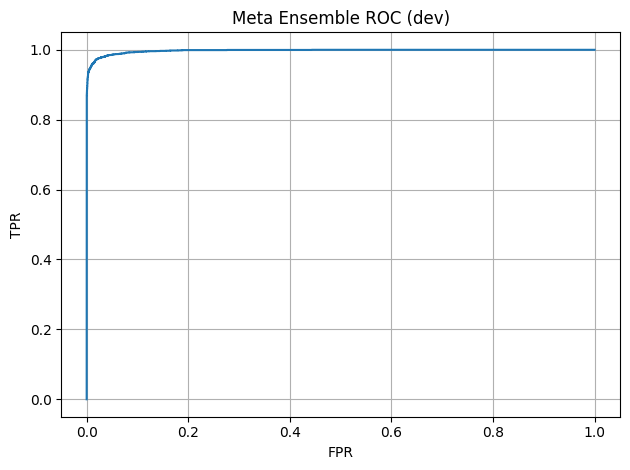

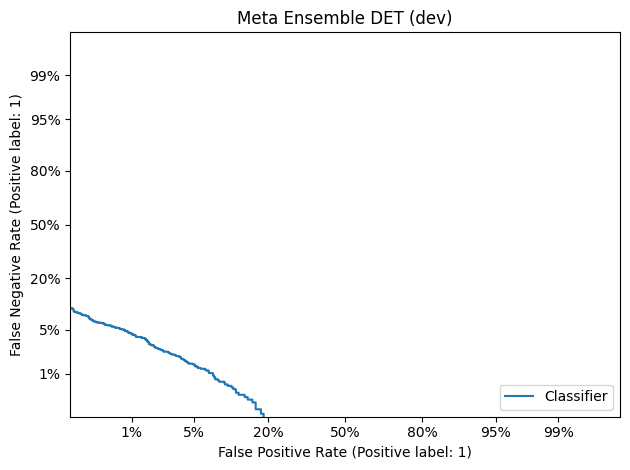

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, DetCurveDisplay

# ROC
fpr, tpr, thr = roc_curve(yv, sv)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Meta Ensemble ROC (dev)")
plt.grid(True); plt.tight_layout(); plt.savefig("meta_roc_dev.png")

# DET
DetCurveDisplay.from_predictions(yv, sv)
plt.title("Meta Ensemble DET (dev)")
plt.tight_layout(); plt.savefig("meta_det_dev.png")


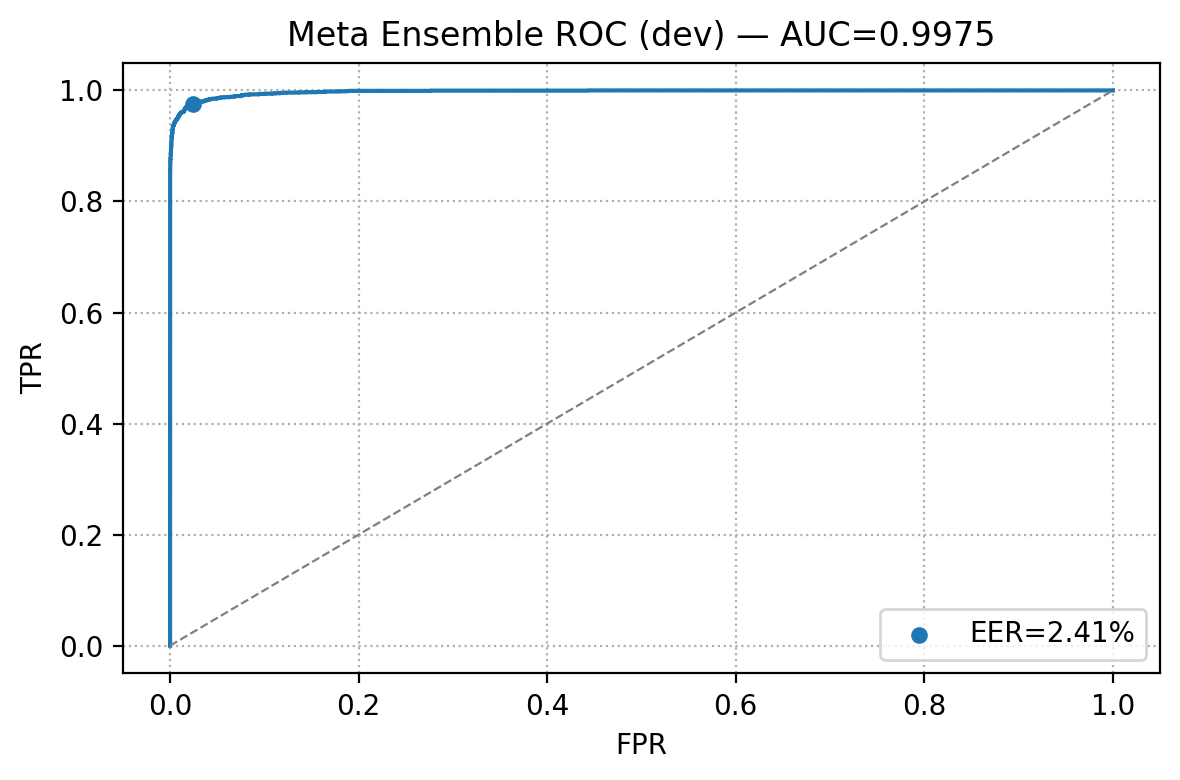

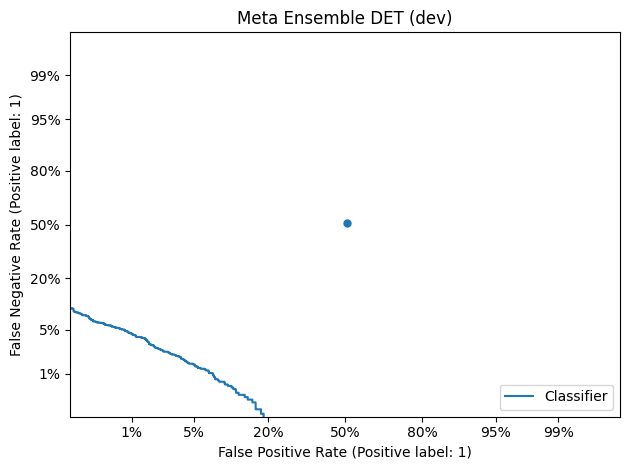

In [34]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, DetCurveDisplay

# yv: (N,), sv: (N,) spoof prob, thr_eer: scalar from your calc
fpr, tpr, thr = roc_curve(yv, sv)
fnr = 1 - tpr
idx = np.argmin(np.abs(fnr - fpr))
eer  = 0.5 * (fnr[idx] + fpr[idx])
thr_eer = thr[idx]
roc_auc = auc(fpr, tpr)

# ROC (hi-res + EER marker)
plt.figure(figsize=(6,4), dpi=200)
plt.plot(fpr, tpr, lw=1.5)
plt.scatter([fpr[idx]], [tpr[idx]], s=25, marker='o', label=f"EER={eer*100:.2f}%")
plt.plot([0,1],[0,1], ls="--", lw=0.8, color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"Meta Ensemble ROC (dev) — AUC={roc_auc:.4f}")
plt.legend(); plt.grid(True, ls=':')
plt.tight_layout(); plt.savefig("meta_roc_dev.svg")  # vector for dissertation

# DET with EER point
DetCurveDisplay.from_predictions(yv, sv)
plt.scatter([fpr[idx]],[fnr[idx]], s=25)
plt.title("Meta Ensemble DET (dev)")
plt.tight_layout(); plt.savefig("meta_det_dev.svg")


/tmp/ipykernel_35/864972976.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


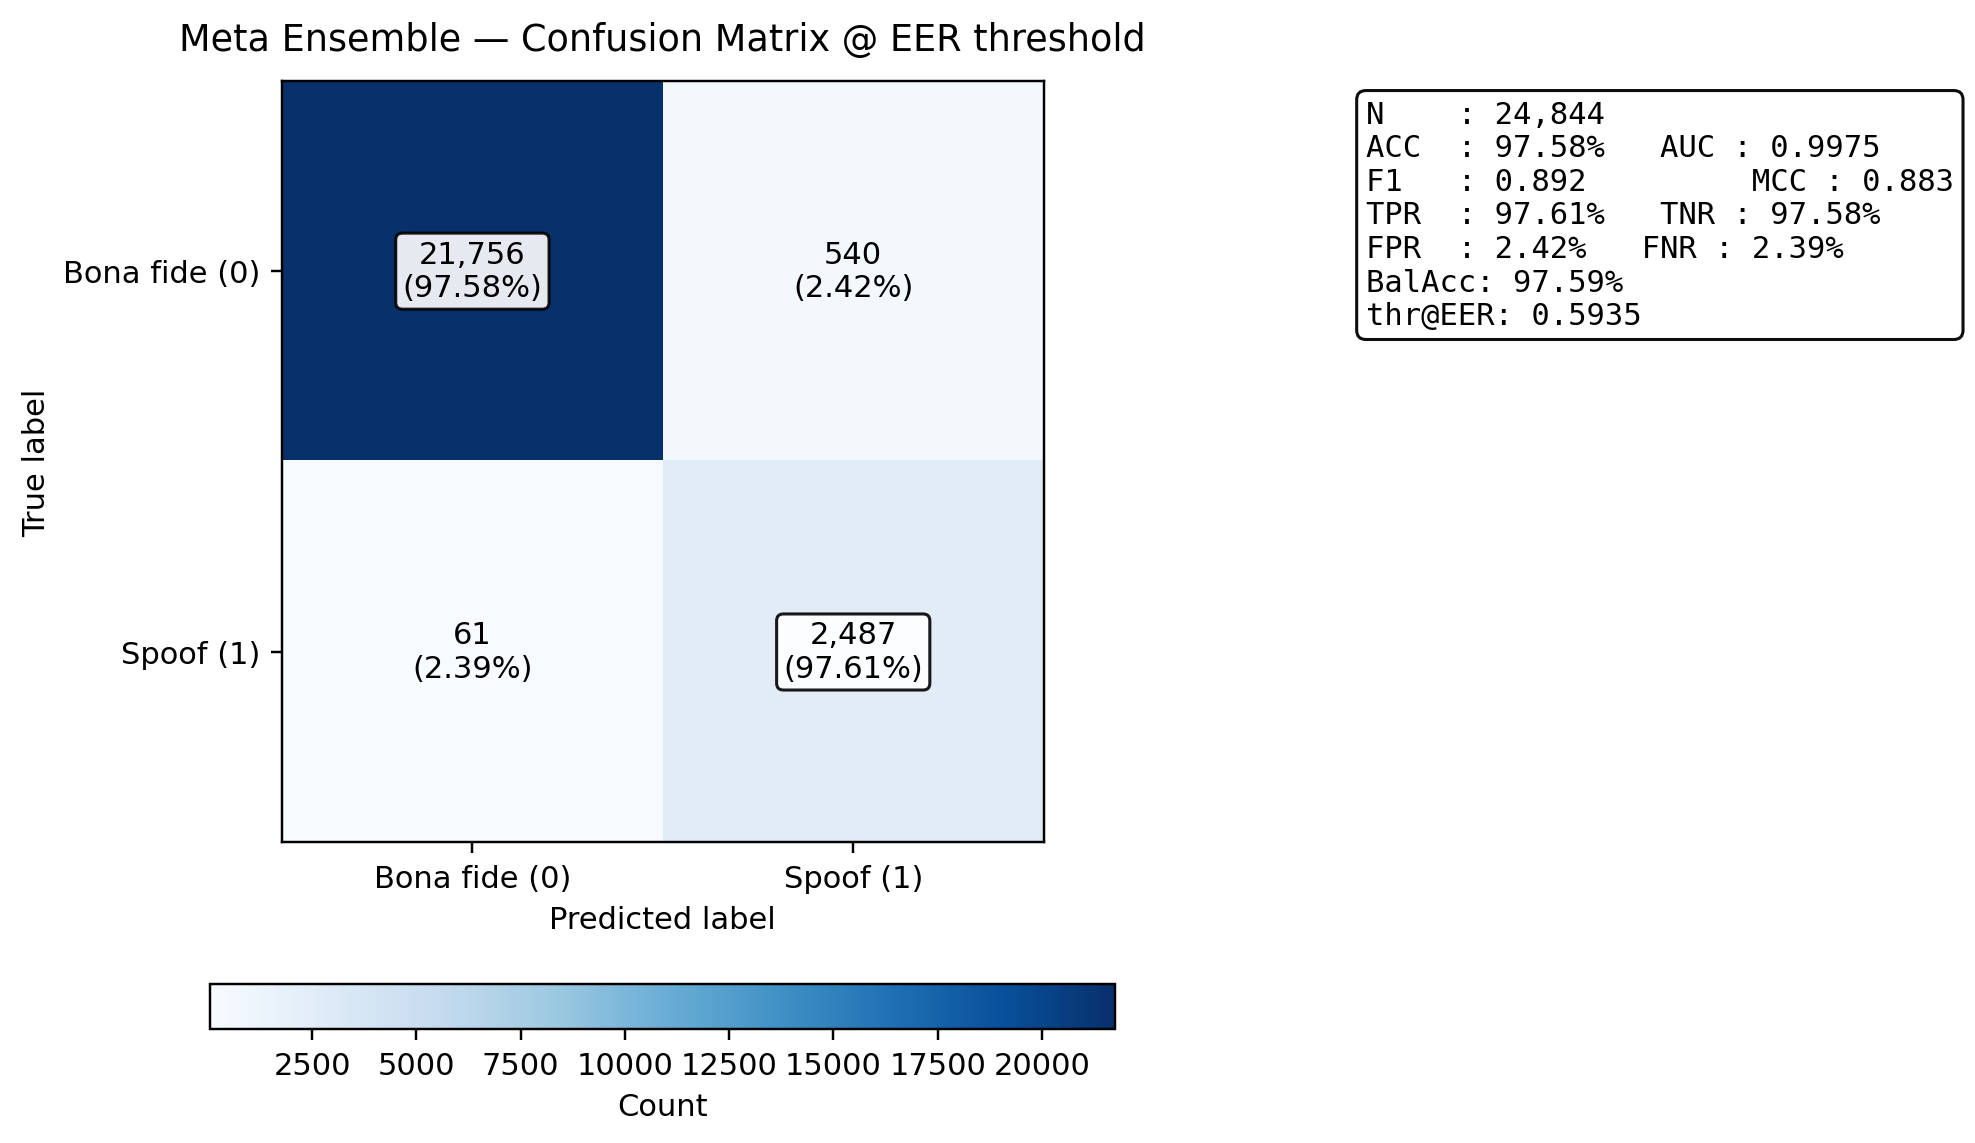

In [38]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix, roc_auc_score, balanced_accuracy_score, matthews_corrcoef

# yv: (N,) ground-truth {0=bona,1=spoof}
# sv: (N,) spoof probabilities
# thr_eer: scalar threshold at EER
pred = (sv >= thr_eer).astype(int)

# Confusion matrix & counts
cm = confusion_matrix(yv, pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
N = cm.sum()

# Rates & scalar metrics
tpr = tp / (tp + fn + 1e-12)   # recall for spoof
fnr = fn / (tp + fn + 1e-12)
tnr = tn / (tn + fp + 1e-12)   # specificity for bona
fpr = fp / (tn + fp + 1e-12)
acc = (tp + tn) / N
prec = tp / (tp + fp + 1e-12)
f1 = 2 * prec * tpr / (prec + tpr + 1e-12)
bal_acc = balanced_accuracy_score(yv, pred)
mcc = matthews_corrcoef(yv, pred)
try:
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(yv, sv)
except Exception:
    auc = float("nan")

# Figure layout: matrix + horizontal colorbar + side panel
fig = plt.figure(figsize=(9.5, 5.6), dpi=220)
gs = GridSpec(nrows=2, ncols=2, width_ratios=[4.2, 2.2], height_ratios=[20, 1.2],
              wspace=0.35, hspace=0.35)

ax_mat  = fig.add_subplot(gs[0, 0])
ax_cbar = fig.add_subplot(gs[1, 0])
ax_info = fig.add_subplot(gs[:, 1])
ax_info.axis('off')

# Confusion matrix image
im = ax_mat.imshow(cm, interpolation='nearest', cmap='Blues')
cb = fig.colorbar(im, cax=ax_cbar, orientation='horizontal')
cb.set_label("Count")

classes = ['Bona fide (0)', 'Spoof (1)']
ax_mat.set_xticks([0,1]); ax_mat.set_yticks([0,1])
ax_mat.set_xticklabels(classes, rotation=0)
ax_mat.set_yticklabels(classes)
ax_mat.set_xlabel('Predicted label'); ax_mat.set_ylabel('True label')
ax_mat.set_title('Meta Ensemble — Confusion Matrix @ EER threshold', pad=10)

# Annotate counts + row %
row_sums = cm.sum(axis=1, keepdims=True)
cm_perc = cm / np.maximum(row_sums, 1)
for i in range(2):
    for j in range(2):
        txt = f'{cm[i,j]:,}\n({cm_perc[i,j]*100:.2f}%)'
        kw = dict(va='center', ha='center', fontsize=10,
                  bbox=dict(boxstyle='round,pad=0.22', facecolor='white', alpha=0.9)) if i==j else dict(va='center', ha='center', fontsize=10)
        ax_mat.text(j, i, txt, **kw)

# Right-side metrics (monospace, left-aligned)
metrics_text = (
    f"N    : {N:,}\n"
    f"ACC  : {acc*100:.2f}%   AUC : {auc:.4f}\n"
    f"F1   : {f1:.3f}         MCC : {mcc:.3f}\n"
    f"TPR  : {tpr*100:.2f}%   TNR : {tnr*100:.2f}%\n"
    f"FPR  : {fpr*100:.2f}%   FNR : {fnr*100:.2f}%\n"
    f"BalAcc: {bal_acc*100:.2f}%\n"
    f"thr@EER: {thr_eer:.4f}"
)
ax_info.text(0.02, 0.98, metrics_text, va='top', ha='left', fontsize=10,
             family='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.95))

plt.tight_layout()
plt.savefig("meta_confusion_dev.svg")   # vector for dissertation
plt.savefig("meta_confusion_dev.png")
plt.show()


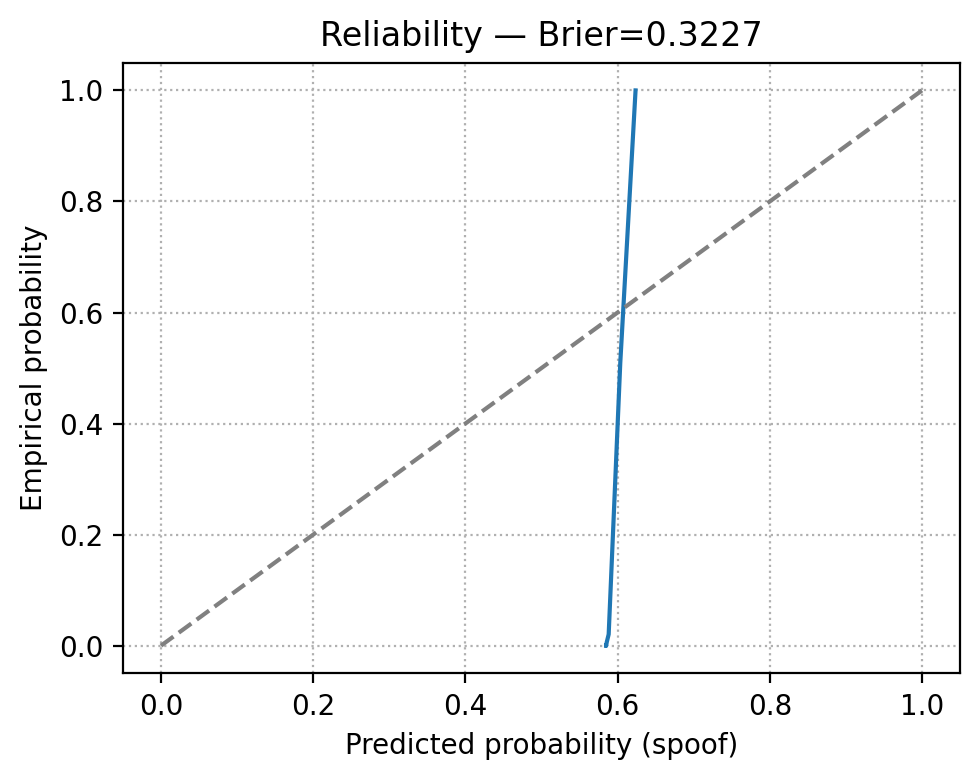

In [36]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(yv, sv, n_bins=15, strategy="quantile")
brier = brier_score_loss(yv, sv)
plt.figure(figsize=(5,4), dpi=200)
plt.plot(prob_pred, prob_true)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Predicted probability (spoof)")
plt.ylabel("Empirical probability")
plt.title(f"Reliability — Brier={brier:.4f}")
plt.grid(True, ls=':'); plt.tight_layout(); plt.savefig("meta_reliability_dev.svg")


# ReMASC testing

In [46]:
# ReMASC: find root
import os, pandas as pd, glob

REMASC_CANDIDATES = [
    "/kaggle/input/remasc-dataa",  # your screenshot path
    "/kaggle/input/remasc-data",
    "/kaggle/input/remasc",
]
REMASC_ROOT = next((p for p in REMASC_CANDIDATES if os.path.exists(p)), None)
assert REMASC_ROOT is not None, "Attach your ReMASC dataset under /kaggle/input."

BASE = os.path.join(REMASC_ROOT, "sample_v2")
WAV_DIR  = os.path.join(BASE, "wav")
META_CSV = os.path.join(BASE, "meta.csv")

# Read metadata
cols = [
    "file_id","speech_type","speaker_id","env_id","pos_id",
    "src_rec_id","playback_id","rec_dev_id","duration_sec"
]
meta = pd.read_csv(META_CSV, header=None, names=cols)

# Keep eval classes: genuine(2) and replayed(3)
meta = meta[meta["speech_type"].isin([2,3])].copy()
meta["label"] = (meta["speech_type"] == 3).astype(int)  # 1=spoof, 0=bona

# Index wavs
all_wavs = glob.glob(os.path.join(WAV_DIR, "**", "*.wav"), recursive=True)
id2path = {os.path.splitext(os.path.basename(p))[0]: p for p in all_wavs}
meta["file_path"] = meta["file_id"].astype(str).map(id2path)
missing = meta["file_path"].isna().sum()
if missing:
    meta = meta.dropna(subset=["file_path"])
    print(f"[ReMASC] Skipped {missing} rows without matching .wav (likely non-eval entries).")

print(f"[ReMASC] usable files: {len(meta)} | bona={int((meta.label==0).sum())} | replayed={int((meta.label==1).sum())}")


[ReMASC] usable files: 8 | bona=4 | replayed=4


In [47]:
import torch, torchaudio, torch.nn.functional as F

# Minimal DF for your dataset class
df_remasc = meta[["file_path","label"]].reset_index(drop=True).copy()

# Try your existing dataset first; else use a fallback one here.
try:
    remasc_ds = ASVspoofMultiModalDataset(df_remasc, ssl_processor, ssl_model, augment=False)
    print("[ReMASC] Using your ASVspoofMultiModalDataset.")
except Exception as e:
    print("[ReMASC] Falling back to a simple dataset:", e)
    SAMPLE_RATE = 16000
    N_MELS = 64
    mel_tf = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE, n_fft=1024, win_length=1024, hop_length=160,
        n_mels=N_MELS, f_min=20.0, f_max=7600.0, power=2.0
    )
    db_tf  = torchaudio.transforms.AmplitudeToDB(top_db=80.0)

    class ReMASC_SpecSSL(torch.utils.data.Dataset):
        def __init__(self, df):
            self.df = df.reset_index(drop=True)
        def __len__(self): return len(self.df)
        def __getitem__(self, i):
            p = self.df.loc[i, "file_path"]; y = int(self.df.loc[i, "label"])
            wav, sr = torchaudio.load(p)
            if wav.size(0) > 1: wav = wav.mean(0, keepdim=True)
            if sr != SAMPLE_RATE:
                wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)
            spec = db_tf(mel_tf(wav)).squeeze(0)   # [F,T]
            # z-score
            m, s = spec.mean(), spec.std().clamp_min(1e-6)
            spec = (spec - m) / s
            # SSL embedding (use your processor/model if present)
            try:
                ipt = ssl_processor(wav.squeeze(0), sampling_rate=SAMPLE_RATE, return_tensors="pt")
                with torch.no_grad():
                    feats = ssl_model(**ipt).last_hidden_state.mean(dim=1).squeeze(0)  # [768]
            except Exception:
                feats = torch.zeros(768)
            return {"ssl": feats, "spectrogram": spec, "label": torch.tensor(y).long()}

    remasc_ds = ReMASC_SpecSSL(df_remasc)

# infer the segment shape your models expect from your ASVspoof dev loader
def infer_segment_shape_from_loader(loader):
    b = next(iter(loader))
    S = b["spectrogram"]
    if S.dim() == 4:                # [B, K, F, T]
        _, K, F, T = S.shape
    elif S.dim() == 3:              # [B, F, T] -> treat as K=1
        K, F, T = 1, S.shape[1], S.shape[2]
    else:
        raise RuntimeError(f"Unexpected spectrogram dims from reference loader: {S.shape}")
    return int(K), int(F), int(T)

K_TARGET, N_MELS_EXP, T_SEG = infer_segment_shape_from_loader(dev_loader_2019)
print(f"[REF] Segment shape -> K={K_TARGET}, F={N_MELS_EXP}, T={T_SEG}")


[ReMASC] Using your ASVspoofMultiModalDataset.
[REF] Segment shape -> K=1, F=64, T=593


In [49]:
import torch, torch.nn.functional as F

SSL_DIM = 768  # adjust if your SSL dim differs

def _to_1d_ssl(x: torch.Tensor, target_dim: int = SSL_DIM) -> torch.Tensor:
    x = x.float()
    if x.dim() == 2: x = x.mean(dim=0)          # [T,D] -> [D]
    elif x.dim() != 1: x = x.view(-1)
    d = x.numel()
    if d > target_dim: x = x[:target_dim]
    if d < target_dim: x = F.pad(x, (0, target_dim - d))
    return x

def _coerce_to_FT(spec: torch.Tensor, F_expect: int) -> torch.Tensor:
    """Return [F_expect, T_total] no matter how 'spec' comes in."""
    s = spec.detach().float()
    if s.dim() == 1:
        n = s.numel()
        if n % F_expect == 0:
            return s.view(F_expect, n // F_expect)
        # try common mel sizes and then resize to F_expect
        for f_guess in (128, 80, 64):
            if n % f_guess == 0:
                t = n // f_guess
                tmp = s.view(1, 1, f_guess, t)
                tmp = F.interpolate(tmp, size=(F_expect, t), mode="bilinear", align_corners=False)
                return tmp.squeeze(0).squeeze(0)
        raise RuntimeError(f"Cannot reshape 1D spec of length {n} to [F,T].")
    if s.dim() == 2:
        F_in, T = s.shape
        if F_in == F_expect:
            return s
        if T == F_expect:      # looks transposed
            return s.t()
        # resize freq to F_expect
        tmp = s.unsqueeze(0).unsqueeze(0)  # [1,1,F_in,T]
        tmp = F.interpolate(tmp, size=(F_expect, T), mode="bilinear", align_corners=False)
        return tmp.squeeze(0).squeeze(0)
    if s.dim() >= 3:
        # Try to find a dimension equal to F_expect (freq). If none, collapse & resize.
        dims = list(s.shape)
        if F_expect in dims:
            f_idx = dims.index(F_expect)
            s = s.moveaxis(f_idx, 0).reshape(F_expect, -1)  # collapse remaining dims into time
            return s
        else:
            s = s.reshape(1, 1, dims[-2], dims[-1])  # assume last two are (F,T)
            s = F.interpolate(s, size=(F_expect, s.shape[-1]), mode="bilinear", align_corners=False)
            return s.squeeze(0).squeeze(0)
    raise RuntimeError(f"Unsupported spec dims: {tuple(s.shape)}")

def _segment_to_fixed_K(spec_FT: torch.Tensor, K_target: int, T_seg: int, F_expect: int) -> torch.Tensor:
    """spec_FT: [F_expect, T_total] -> [K_target, F_expect, T_seg] with down/upsampling on K."""
    if spec_FT.size(0) != F_expect:
        # pad or crop freq to F_expect
        if spec_FT.size(0) > F_expect:
            spec_FT = spec_FT[:F_expect, :]
        else:
            spec_FT = F.pad(spec_FT, (0, 0, 0, F_expect - spec_FT.size(0)))
    Freq, Ttot = spec_FT.shape
    segs = []
    kmax = max(1, Ttot // T_seg)
    for k in range(kmax):
        s, e = k * T_seg, k * T_seg + T_seg
        if e > Ttot: break
        segs.append(spec_FT[:, s:e])
    if not segs:
        segs = [spec_FT[:, :T_seg] if Ttot >= T_seg else F.pad(spec_FT, (0, T_seg - Ttot))]
    # reduce/expand to exactly K_target
    if len(segs) > K_target:
        idx = torch.linspace(0, len(segs) - 1, steps=K_target).round().long().tolist()
        segs = [segs[i] for i in idx]
    while len(segs) < K_target:
        segs.append(segs[-1])
    return torch.stack(segs, dim=0)  # [K_target, F_expect, T_seg]

def collate_remasc_fixed(batch):
    fixed = []
    for it in batch:
        it = dict(it)
        # 1) SSL -> 1D
        it["ssl"] = _to_1d_ssl(it.get("ssl", torch.zeros(SSL_DIM)))
        # 2) Spec -> [F,T_total]
        spec = it["spectrogram"]
        if spec.dim() == 3 and spec.size(0) == 1:  # [1,F,T] -> [F,T]
            spec = spec.squeeze(0)
        spec_FT = _coerce_to_FT(spec, N_MELS_EXP)
        # z-score
        m, s = spec_FT.mean(), spec_FT.std().clamp_min(1e-6)
        spec_FT = (spec_FT - m) / s
        # 3) Segment to fixed K×F×T
        it["spectrogram"] = _segment_to_fixed_K(spec_FT, K_TARGET, T_SEG, N_MELS_EXP)
        fixed.append(it)
    # Hand off to your existing collate (now everything has consistent shapes)
    return multimodal_collate_fn(fixed, apply_augment=False)


In [50]:
from torch.utils.data import DataLoader
remasc_loader = DataLoader(remasc_ds, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_remasc_fixed)

b = next(iter(remasc_loader))
print({k: (v.shape if torch.is_tensor(v) else type(v)) for k,v in b.items()})
# Expect: {'ssl': [B,768], 'spectrogram': [B, K_TARGET, N_MELS_EXP, T_SEG], 'label': [B]}


{'ssl': torch.Size([8, 768]), 'spectrogram': torch.Size([8, 1, 64, 593]), 'label': torch.Size([8])}


In [52]:
# --- PATCH: make models robust to [B,K,F,T] by flattening K onto time ---
import torch.nn.functional as F
import torch

def _prepare_spec_for_model(spec: torch.Tensor) -> torch.Tensor:
    """
    Ensure the spectrogram fed to base models is [B, F, T].
    If we get [B, K, F, T], either squeeze K=1, or flatten to [B, F, K*T].
    """
    if spec is None:
        return spec
    if spec.dim() == 4:                          # [B, K, F, T]
        B, K, Freq, T = spec.shape
        if K == 1:
            return spec[:, 0]                    # -> [B, F, T]
        # concatenate segments along time: [B, F, K*T]
        return spec.permute(0, 2, 1, 3).reshape(B, Freq, K * T)
    elif spec.dim() == 3:                         # already [B, F, T]
        return spec
    elif spec.dim() == 2:                         # [F, T] -> add batch dim (rare in collate)
        return spec.unsqueeze(0)
    else:
        # last resort: collapse to [B, F, T] assuming last two are [F, T]
        return spec.reshape(spec.size(0), spec.size(-2), spec.size(-1))

# Replace your _forward_score with this version
def _forward_score(model, ssl, spec, spoof_idx=1):
    """
    Returns (B,) spoof probability for one model.
    - Normalizes outputs (Tensor/tuple/dict) to class logits
    - Accepts either model(ssl, spec) or model(spec)
    - Handles models that return 2 logits or 1 logit
    """
    spec_in = _prepare_spec_for_model(spec)

    try:
        out = model(ssl, spec_in)
    except TypeError:
        out = model(spec_in)
    except Exception:
        # Fallback: try the original spec in case a model really expects [B,K,F,T]
        try:
            out = model(ssl, spec)
        except TypeError:
            out = model(spec)

    # --- pick class logits no matter the return type ---
    if isinstance(out, torch.Tensor):
        logits = out
    elif isinstance(out, (tuple, list)):
        logits = next((o for o in out if isinstance(o, torch.Tensor)), None)
        if logits is None: raise TypeError("Model returned a tuple/list without Tensor.")
    elif isinstance(out, dict):
        for k in ("logits","cls_logits","y_logits","scores","output"):
            if k in out and isinstance(out[k], torch.Tensor):
                logits = out[k]; break
        else:
            logits = next((v for v in out.values() if isinstance(v, torch.Tensor)), None)
            if logits is None: raise TypeError("Model returned a dict without any Tensor.")
    else:
        raise TypeError(f"Unsupported model output type: {type(out)}")

    # --- convert to spoof probability ---
    if logits.dim() == 2 and logits.size(1) >= 2:
        probs = F.softmax(logits, dim=1)[:, spoof_idx]
    else:
        probs = torch.sigmoid(logits.view(-1))
    return probs  # (B,)


In [54]:
# use the reference segment shape you already inferred from ASVspoof:
# K_TARGET, N_MELS_EXP, T_SEG  (if you haven't: see earlier cell that infers it from dev_loader_2019)

SSL_DIM = 768  # adapt if your SSL dim differs

def _to_1d_ssl(x: torch.Tensor, target_dim: int = SSL_DIM) -> torch.Tensor:
    x = x.float()
    if x.dim() == 2: x = x.mean(dim=0)          # [T,D] -> [D]
    elif x.dim() != 1: x = x.view(-1)
    d = x.numel()
    if d > target_dim: x = x[:target_dim]
    if d < target_dim: x = F.pad(x, (0, target_dim - d))
    return x

def _coerce_to_FT(spec: torch.Tensor, F_expect: int) -> torch.Tensor:
    """Return [F_expect, T_total] no matter how 'spec' comes in."""
    s = spec.detach().float()
    if s.dim() == 1:
        n = s.numel()
        if n % F_expect == 0:
            return s.view(F_expect, n // F_expect)
        # try common mel sizes; then resize to F_expect
        for f_guess in (128, 80, 64):
            if n % f_guess == 0:
                t = n // f_guess
                tmp = s.view(1,1,f_guess,t)
                tmp = F.interpolate(tmp, size=(F_expect, t), mode="bilinear", align_corners=False)
                return tmp.squeeze(0).squeeze(0)
        raise RuntimeError(f"Cannot reshape 1D spec of length {n} to [F,T].")
    if s.dim() == 2:
        F_in, T = s.shape
        if F_in == F_expect: return s
        if T == F_expect:    return s.t()
        tmp = s.unsqueeze(0).unsqueeze(0)  # [1,1,F_in,T]
        tmp = F.interpolate(tmp, size=(F_expect, T), mode="bilinear", align_corners=False)
        return tmp.squeeze(0).squeeze(0)
    if s.dim() >= 3:
        # If any dim equals F_expect, move it to freq; else collapse and resize
        dims = list(s.shape)
        if F_expect in dims:
            f_idx = dims.index(F_expect)
            s = s.moveaxis(f_idx, 0).reshape(F_expect, -1)
            return s
        else:
            s = s.reshape(1,1,dims[-2], dims[-1])  # assume last two ~ (F,T)
            s = F.interpolate(s, size=(F_expect, s.shape[-1]), mode="bilinear", align_corners=False)
            return s.squeeze(0).squeeze(0)
    raise RuntimeError(f"Unsupported spec dims: {tuple(s.shape)}")

def _slice_to_fixed_totalT(spec_FT: torch.Tensor, K_target: int, T_seg: int, F_expect: int) -> torch.Tensor:
    """
    Return [F_expect, K_target*T_seg]: center-crop or pad along time to the exact total length.
    """
    totalT = K_target * T_seg
    if spec_FT.size(0) != F_expect:
        if spec_FT.size(0) > F_expect: spec_FT = spec_FT[:F_expect, :]
        else: spec_FT = F.pad(spec_FT, (0,0,0, F_expect - spec_FT.size(0)))
    Freq, Ttot = spec_FT.shape
    if Ttot == totalT:
        return spec_FT
    if Ttot > totalT:
        # center crop
        start = max(0, (Ttot - totalT)//2)
        return spec_FT[:, start:start+totalT]
    else:
        # pad at the end
        return F.pad(spec_FT, (0, totalT - Ttot))

def collate_remasc_flat(batch):
    """
    Outputs:
      ssl:  [B, 768]
      spec: [B, F, K_TARGET*T_SEG]  (one utterance → one long segment)
      y:    [B]
    Ensures exactly one label per utterance (no K-duplication).
    """
    ssl_list, spec_list, y_list = [], [], []
    for it in batch:
        # SSL
        ssl_vec = _to_1d_ssl(it.get("ssl", torch.zeros(SSL_DIM)))
        # Spec
        spec = it["spectrogram"]
        if spec.dim() == 3 and spec.size(0) == 1: spec = spec.squeeze(0)
        spec_FT = _coerce_to_FT(spec, N_MELS_EXP)
        # z-score
        m, s = spec_FT.mean(), spec_FT.std().clamp_min(1e-6)
        spec_FT = (spec_FT - m) / s
        # fix total time to K*T
        spec_fix = _slice_to_fixed_totalT(spec_FT, K_TARGET, T_SEG, N_MELS_EXP)  # [F, K*T]
        ssl_list.append(ssl_vec)
        spec_list.append(spec_fix)
        y_list.append(int(it["label"]))
    return {
        "ssl": torch.stack(ssl_list, 0),        # [B, 768]
        "spectrogram": torch.stack(spec_list,0),# [B, F, K*T]
        "label": torch.tensor(y_list).long(),   # [B]
    }


In [58]:
import torch, torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
SPOOF_IDX = 1  # set to 0 if your meta uses [spoof, bona] ordering

def _pick_class_logits(output):
    if isinstance(output, torch.Tensor):
        return output
    if isinstance(output, (tuple, list)):
        for o in output:
            if isinstance(o, torch.Tensor):
                return o
        raise TypeError("No Tensor in tuple/list output.")
    if isinstance(output, dict):
        for k in ("logits","cls_logits","y_logits","scores","output"):
            if k in output and isinstance(output[k], torch.Tensor):
                return output[k]
        for v in output.values():
            if isinstance(v, torch.Tensor):
                return v
        raise TypeError("No Tensor in dict output.")
    raise TypeError(f"Unsupported model output type: {type(output)}")

def _forward_spoof_prob(model, ssl, spec, spoof_idx=SPOOF_IDX):
    # model may expect (ssl, spec) or just (spec); outputs can be 1- or 2-logit
    try:
        out = model(ssl, spec)
    except TypeError:
        out = model(spec)
    logits = _pick_class_logits(out)
    if logits.dim() == 2 and logits.size(1) >= 2:
        return F.softmax(logits, dim=1)[:, spoof_idx]   # (B,)
    return torch.sigmoid(logits.view(-1))               # (B,)

@torch.no_grad()
def eval_meta_on_remasc(models, meta_model, loader, device=None, spoof_idx=SPOOF_IDX):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    for m in models: m.eval().to(device)
    meta_model = meta_model.eval().to(device)

    all_meta_scores, all_labels = [], []

    for batch in loader:
        ssl = batch["ssl"].to(device)          # [B, 768] (or whatever your SSL dim is)
        spec = batch["spectrogram"].to(device) # [B, F, T]
        y    = batch["label"].cpu().numpy().astype(int)  # [B]

        # base scores -> [B, num_models]
        per_model = []
        for m in models:
            s = _forward_spoof_prob(m, ssl, spec, spoof_idx=spoof_idx)  # (B,)
            per_model.append(s.unsqueeze(1))
        X = torch.cat(per_model, dim=1)        # [B, num_models]

        # --- META: handle 1- or 2-logit outputs ---
        meta_out = meta_model(X)               # could be Tensor / tuple / dict
        meta_logits = _pick_class_logits(meta_out)
        if meta_logits.dim() == 2 and meta_logits.size(1) >= 2:
            meta_scores = F.softmax(meta_logits, dim=1)[:, spoof_idx].cpu().numpy()
        else:
            meta_scores = torch.sigmoid(meta_logits.view(-1)).cpu().numpy()

        assert meta_scores.shape[0] == y.shape[0], (
            f"labels and scores must align: scores={meta_scores.shape} labels={y.shape} "
            f"(meta_logits shape={tuple(meta_logits.shape)})"
        )

        all_meta_scores.append(meta_scores)
        all_labels.append(y)

    scores = np.concatenate(all_meta_scores, axis=0)     # (N,)
    labels = np.concatenate(all_labels, axis=0)          # (N,)
    return scores, labels

# ---- run it ----
s_remasc, yr = eval_meta_on_remasc(models, meta_model, remasc_loader, device=device, spoof_idx=SPOOF_IDX)
print("Aligned shapes — scores:", s_remasc.shape, "labels:", yr.shape)

# EER on ReMASC (positive=1 = spoof)
fpr, tpr, thr = roc_curve(yr, s_remasc)
fnr = 1 - tpr
idx = np.argmin(np.abs(fnr - fpr))
eer_remasc  = 0.5 * (fnr[idx] + fpr[idx])
thr_remasc  = thr[idx]
print(f"[ReMASC] EER = {eer_remasc*100:.2f}% | thr@EER = {thr_remasc:.4f}")

# Evaluate at your LA-dev threshold (transfer)
thr_dev = float(thr_eer) if "thr_eer" in globals() else thr_remasc
pred_dev = (s_remasc >= thr_dev).astype(int)
cm = confusion_matrix(yr, pred_dev, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print(f"[ReMASC @ dev-thr={thr_dev:.4f}] TN={tn} FP={fp} FN={fn} TP={tp}")


Aligned shapes — scores: (8,) labels: (8,)
[ReMASC] EER = 75.00% | thr@EER = 0.5849
[ReMASC @ dev-thr=0.5935] TN=4 FP=0 FN=4 TP=0


Testing on all other models (A,B,C and Ensemble Model)

In [59]:
import torch, torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

device = "cuda" if torch.cuda.is_available() else "cpu"

def _pick_class_logits(output):
    if isinstance(output, torch.Tensor): return output
    if isinstance(output, (tuple, list)):
        for o in output:
            if isinstance(o, torch.Tensor): return o
    if isinstance(output, dict):
        for k in ("logits","cls_logits","y_logits","scores","output"):
            if k in output and isinstance(output[k], torch.Tensor):
                return output[k]
        for v in output.values():
            if isinstance(v, torch.Tensor): return v
    raise TypeError("Unsupported model output type.")

@torch.no_grad()
def remasc_per_model_scores(models, meta_model, loader, spoof_idx=1, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    for m in models: m.eval().to(device)
    meta_model = meta_model.eval().to(device)

    base_scores = [ [] for _ in models ]  # list of lists
    meta_scores = []
    labels_all  = []

    for batch in loader:
        ssl  = batch["ssl"].to(device)          # [B,768]
        spec = batch["spectrogram"].to(device)  # [B,F,T]  (from your remasc_flat collate)
        y    = batch["label"].cpu().numpy().astype(int)

        per_m = []
        for mi, m in enumerate(models):
            try:
                out = m(ssl, spec)
            except TypeError:
                out = m(spec)
            logits = _pick_class_logits(out)
            if logits.dim() == 2 and logits.size(1) >= 2:
                s = F.softmax(logits, dim=1)[:, spoof_idx]
            else:
                s = torch.sigmoid(logits.view(-1))
            base_scores[mi].append(s.cpu().numpy())
            per_m.append(s.unsqueeze(1))

        X = torch.cat(per_m, dim=1)           # [B,3]
        mout = meta_model(X)
        mlog = _pick_class_logits(mout)
        if mlog.dim() == 2 and mlog.size(1) >= 2:
            ms = F.softmax(mlog, dim=1)[:, spoof_idx]
        else:
            ms = torch.sigmoid(mlog.view(-1))
        meta_scores.append(ms.cpu().numpy())
        labels_all.append(y)

    S_base = [ np.concatenate(bs) if len(bs) else np.array([]) for bs in base_scores ]
    S_meta = np.concatenate(meta_scores) if len(meta_scores) else np.array([])
    Y      = np.concatenate(labels_all) if len(labels_all) else np.array([])
    return S_base, S_meta, Y

def eer_from_scores(y, s):
    if len(np.unique(y)) < 2: return np.nan, np.nan
    fpr, tpr, thr = roc_curve(y, s)
    fnr = 1 - tpr
    i = np.argmin(np.abs(fnr - fpr))
    eer = 0.5*(fnr[i] + fpr[i])
    return eer, thr[i]

S_base, S_meta, Y = remasc_per_model_scores(models, meta_model, remasc_loader, spoof_idx=1, device=device)

names = ["Model A","Model B","Model C","Meta"]
for i, s in enumerate(S_base + [S_meta]):
    if s.size == 0:
        print(f"{names[i]}: no scores")
        continue
    try:
        auc = roc_auc_score(Y, s)
    except Exception:
        auc = float('nan')
    eer, thr = eer_from_scores(Y, s)
    print(f"{names[i]} — N={len(s)} | AUC={auc:.3f} | EER={eer*100:.2f}% | thr@EER={thr:.4f}")


Model A — N=8 | AUC=0.312 | EER=50.00% | thr@EER=0.0001
Model B — N=8 | AUC=0.375 | EER=37.50% | thr@EER=0.0002
Model C — N=8 | AUC=0.375 | EER=50.00% | thr@EER=0.9997
Meta — N=8 | AUC=0.281 | EER=75.00% | thr@EER=0.5849


# Segmented Testing on ReMASC data

In [62]:
# ---- SEGMENTED COLLATE (returns k_counts) ----
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader

# infer the segment config your models expect from ASVspoof dev loader
def _infer_segment_shape_from_loader(loader):
    b = next(iter(loader))
    S = b["spectrogram"]
    if S.dim() == 4:  # [B,K,F,T]
        _, K, Freq, T = S.shape
    elif S.dim() == 3:  # [B,F,T] -> treat as K=1
        K, Freq, T = 1, S.shape[1], S.shape[2]
    else:
        raise RuntimeError(f"Unexpected spectrogram dims: {tuple(S.shape)}")
    return int(K), int(Freq), int(T)

K_TARGET, N_MELS_EXP, T_SEG = _infer_segment_shape_from_loader(dev_loader_2019)
SSL_DIM = 768  # change if your SSL size differs

def _to_1d_ssl(x: torch.Tensor, target_dim: int = SSL_DIM) -> torch.Tensor:
    x = x.float()
    if x.dim() == 2: x = x.mean(dim=0)      # [T,D] -> [D]
    elif x.dim() != 1: x = x.view(-1)
    d = x.numel()
    if d > target_dim: x = x[:target_dim]
    if d < target_dim: x = F.pad(x, (0, target_dim - d))
    return x

def _coerce_to_FT(spec: torch.Tensor, F_expect: int) -> torch.Tensor:
    s = spec.detach().float()
    if s.dim() == 1:
        n = s.numel()
        if n % F_expect == 0: return s.view(F_expect, n // F_expect)
        for f_guess in (128, 80, 64):
            if n % f_guess == 0:
                t = n // f_guess
                tmp = s.view(1,1,f_guess,t)
                tmp = F.interpolate(tmp, size=(F_expect, t), mode="bilinear", align_corners=False)
                return tmp.squeeze(0).squeeze(0)
        raise RuntimeError(f"Cannot reshape 1D spec length {n} to [F,T].")
    if s.dim() == 2:
        F_in, T = s.shape
        if F_in == F_expect: return s
        if T    == F_expect: return s.t()
        tmp = s.unsqueeze(0).unsqueeze(0)
        tmp = F.interpolate(tmp, size=(F_expect, T), mode="bilinear", align_corners=False)
        return tmp.squeeze(0).squeeze(0)
    dims = list(s.shape)  # >=3D
    if F_expect in dims:
        f_idx = dims.index(F_expect)
        return s.moveaxis(f_idx, 0).reshape(F_expect, -1)
    s = s.reshape(1,1,dims[-2], dims[-1])  # assume last two ~ (F,T)
    s = F.interpolate(s, size=(F_expect, s.shape[-1]), mode="bilinear", align_corners=False)
    return s.squeeze(0).squeeze(0)

def _segment_FT_to_KFT(spec_FT: torch.Tensor, T_seg: int, F_expect: int, overlap: int = 0, k_max: int = 32):
    if spec_FT.size(0) != F_expect:
        if spec_FT.size(0) > F_expect: spec_FT = spec_FT[:F_expect, :]
        else: spec_FT = F.pad(spec_FT, (0,0,0, F_expect - spec_FT.size(0)))
    Freq, Ttot = spec_FT.shape
    step = max(1, T_seg - overlap)
    segs = []
    for s in range(0, max(1, Ttot - T_seg + 1), step):
        e = s + T_seg
        if e > Ttot: break
        segs.append(spec_FT[:, s:e])
        if len(segs) >= k_max: break
    if not segs:
        segs = [spec_FT[:, :T_seg] if Ttot >= T_seg else F.pad(spec_FT, (0, T_seg - Ttot))]
    return torch.stack(segs, dim=0)  # [K,F,T_seg]

def collate_remasc_segmented(batch, overlap_frames: int = 0, k_max: int = 32):
    """
    Returns:
      ssl:  [B, 768]
      spectrogram: [B, K_max, F, T]
      label: [B]
      k_counts: [B]  (true K for each item before padding)
    """
    ssl_list, specK_list, y_list = [], [], []
    for it in batch:
        ssl_vec = _to_1d_ssl(it.get("ssl", torch.zeros(SSL_DIM)))
        spec = it["spectrogram"]
        if spec.dim() == 3 and spec.size(0) == 1: spec = spec.squeeze(0)
        spec_FT = _coerce_to_FT(spec, N_MELS_EXP)
        m, s = spec_FT.mean(), spec_FT.std().clamp_min(1e-6)  # match training norm
        spec_FT = (spec_FT - m) / s
        spec_KFT = _segment_FT_to_KFT(spec_FT, T_SEG, N_MELS_EXP, overlap=overlap_frames, k_max=k_max)
        ssl_list.append(ssl_vec)
        specK_list.append(spec_KFT)
        y_list.append(int(it["label"]))

    K_list = [x.size(0) for x in specK_list]
    K_max = max(K_list)
    spec_padded = []
    for x in specK_list:
        if x.size(0) < K_max:
            pad = x[-1:].expand(K_max - x.size(0), -1, -1)
            x = torch.cat([x, pad], dim=0)
        spec_padded.append(x)
    return {
        "ssl": torch.stack(ssl_list, 0),                  # [B,768]
        "spectrogram": torch.stack(spec_padded, 0),       # [B,K_max,F,T]
        "label": torch.tensor(y_list).long(),             # [B]
        "k_counts": torch.tensor(K_list).long(),          # [B]
    }

# ---- Rebuild the loader to use the new collate ----
remasc_loader = DataLoader(
    remasc_ds,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=lambda b: collate_remasc_segmented(b, overlap_frames=0, k_max=32)
)

b = next(iter(remasc_loader))
print({k: (v.shape if torch.is_tensor(v) else type(v)) for k,v in b.items()})
# Expect: {'ssl': [B,768], 'spectrogram': [B,K,F,T], 'label':[B], 'k_counts':[B]}


{'ssl': torch.Size([8, 768]), 'spectrogram': torch.Size([8, 3, 64, 593]), 'label': torch.Size([8]), 'k_counts': torch.Size([8])}


In [63]:
import torch, torch.nn.functional as F

# Reuse the segment shape your models expect (infer once from your ASVspoof dev loader)
def infer_segment_shape_from_loader(loader):
    b = next(iter(loader))
    S = b["spectrogram"]
    if S.dim() == 4:  # [B,K,F,T]
        _, K, Freq, T = S.shape
    elif S.dim() == 3:  # [B,F,T] -> treat as K=1
        K, Freq, T = 1, S.shape[1], S.shape[2]
    else:
        raise RuntimeError(f"Unexpected spec dims: {tuple(S.shape)}")
    return int(K), int(Freq), int(T)

K_TARGET, N_MELS_EXP, T_SEG = infer_segment_shape_from_loader(dev_loader_2019)
print(f"[REF] segment config -> K(any), F={N_MELS_EXP}, T={T_SEG}")

SSL_DIM = 768  # change if your SSL size differs

def _to_1d_ssl(x: torch.Tensor, target_dim: int = SSL_DIM) -> torch.Tensor:
    x = x.float()
    if x.dim() == 2: x = x.mean(dim=0)      # [T,D] -> [D]
    elif x.dim() != 1: x = x.view(-1)
    d = x.numel()
    if d > target_dim: x = x[:target_dim]
    if d < target_dim: x = F.pad(x, (0, target_dim - d))
    return x

def _coerce_to_FT(spec: torch.Tensor, F_expect: int) -> torch.Tensor:
    s = spec.detach().float()
    if s.dim() == 1:
        n = s.numel()
        if n % F_expect == 0: return s.view(F_expect, n // F_expect)
        for f_guess in (128, 80, 64):
            if n % f_guess == 0:
                t = n // f_guess
                tmp = s.view(1,1,f_guess,t)
                tmp = F.interpolate(tmp, size=(F_expect, t), mode="bilinear", align_corners=False)
                return tmp.squeeze(0).squeeze(0)
        raise RuntimeError(f"Cannot reshape 1D spec length {n} to [F,T].")
    if s.dim() == 2:
        F_in, T = s.shape
        if F_in == F_expect: return s
        if T == F_expect:    return s.t()
        tmp = s.unsqueeze(0).unsqueeze(0)
        tmp = F.interpolate(tmp, size=(F_expect, T), mode="bilinear", align_corners=False)
        return tmp.squeeze(0).squeeze(0)
    # >=3D: try to find freq dim or fall back to last-two as (F,T)
    dims = list(s.shape)
    if F_expect in dims:
        f_idx = dims.index(F_expect)
        return s.moveaxis(f_idx, 0).reshape(F_expect, -1)
    s = s.reshape(1,1,dims[-2], dims[-1])
    s = F.interpolate(s, size=(F_expect, s.shape[-1]), mode="bilinear", align_corners=False)
    return s.squeeze(0).squeeze(0)

def _segment_FT_to_KFT(spec_FT: torch.Tensor, T_seg: int, F_expect: int, overlap: int = 0, k_max: int = 32):
    """Spec: [F,T] -> list of [F,T_seg] windows; allow small overlap and cap K for speed."""
    if spec_FT.size(0) != F_expect:
        if spec_FT.size(0) > F_expect: spec_FT = spec_FT[:F_expect, :]
        else: spec_FT = F.pad(spec_FT, (0,0,0, F_expect - spec_FT.size(0)))
    Freq, Ttot = spec_FT.shape
    step = max(1, T_seg - overlap)
    segs = []
    for s in range(0, max(1, Ttot - T_seg + 1), step):
        e = s + T_seg
        if e > Ttot: break
        segs.append(spec_FT[:, s:e])
        if len(segs) >= k_max: break
    if not segs:
        segs = [spec_FT[:, :T_seg] if Ttot >= T_seg else F.pad(spec_FT, (0, T_seg - Ttot))]
    return torch.stack(segs, dim=0)  # [K,F,T_seg]

def collate_remasc_segmented(batch, overlap_frames: int = 0, k_max: int = 32):
    """
    Returns:
      ssl:  [B, 768]
      spec: [B, K, F, T]  (K varies per item; OK)
      y:    [B]
    """
    ssl_list, specK_list, y_list = [], [], []
    for it in batch:
        # SSL to [768]
        ssl_vec = _to_1d_ssl(it.get("ssl", torch.zeros(SSL_DIM)))
        # Spectrogram to [F,T]
        spec = it["spectrogram"]
        if spec.dim() == 3 and spec.size(0) == 1: spec = spec.squeeze(0)
        spec_FT = _coerce_to_FT(spec, N_MELS_EXP)
        # z-score (match training)
        m, s = spec_FT.mean(), spec_FT.std().clamp_min(1e-6)
        spec_FT = (spec_FT - m) / s
        # Segment to [K,F,T_seg]
        spec_KFT = _segment_FT_to_KFT(spec_FT, T_SEG, N_MELS_EXP, overlap=overlap_frames, k_max=k_max)
        ssl_list.append(ssl_vec)
        specK_list.append(spec_KFT)
        y_list.append(int(it["label"]))
    # pad K to max K in batch so we can stack
    K_list = [x.size(0) for x in specK_list]
    K_max = max(K_list)
    spec_padded = []
    for x in specK_list:
        if x.size(0) < K_max:
            pad = x[-1:].expand(K_max - x.size(0), -1, -1)
            x = torch.cat([x, pad], dim=0)
        spec_padded.append(x)  # [K_max,F,T_seg]
    return {
        "ssl": torch.stack(ssl_list, 0),                  # [B,768]
        "spectrogram": torch.stack(spec_padded, 0),       # [B,K_max,F,T_seg]
        "label": torch.tensor(y_list).long(),             # [B]
        "k_counts": torch.tensor(K_list).long(),          # [B] (true K before padding)
    }


[REF] segment config -> K(any), F=64, T=593


In [64]:
import torch, torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
SPOOF_IDX = 1  # change to 0 if your classifiers use [spoof,bona] ordering

def _pick_class_logits(output):
    if isinstance(output, torch.Tensor): return output
    if isinstance(output, (tuple, list)):
        for o in output:
            if isinstance(o, torch.Tensor): return o
    if isinstance(output, dict):
        for k in ("logits","cls_logits","y_logits","scores","output"):
            if k in output and isinstance(output[k], torch.Tensor): return output[k]
        for v in output.values():
            if isinstance(v, torch.Tensor): return v
    raise TypeError("Unsupported model output type.")

def _forward_spoof_prob_segments(model, ssl_B768, spec_BKFT, K_true, spoof_idx=SPOOF_IDX):
    """
    Run model on each [F,T] segment: spec_BKFT -> [B*K, F, T]; repeat ssl per segment.
    Returns pooled utterance scores [B], and raw per-segment scores [B,K_max].
    """
    B, Kmax, Freq, Tseg = spec_BKFT.shape
    # Build a mask for valid segments
    mask = torch.arange(Kmax, device=spec_BKFT.device).unsqueeze(0) < K_true.unsqueeze(1)  # [B,Kmax]
    # Flatten to [B*Kmax, F, T]
    spec_flat = spec_BKFT.reshape(B*Kmax, Freq, Tseg)
    # Repeat SSL per segment
    ssl_flat  = ssl_B768.unsqueeze(1).expand(B, Kmax, -1).reshape(B*Kmax, -1)
    # Forward
    try:
        out = model(ssl_flat, spec_flat)
    except TypeError:
        out = model(spec_flat)
    logits = _pick_class_logits(out)
    if logits.dim() == 2 and logits.size(1) >= 2:
        scores_flat = F.softmax(logits, dim=1)[:, spoof_idx]
    else:
        scores_flat = torch.sigmoid(logits.view(-1))
    scores_BK = scores_flat.view(B, Kmax)  # per-segment
    return scores_BK, mask  # [B,Kmax], [B,Kmax] bool

def _pool_scores(scores_BK, mask, mode="logit-mean", topk=3):
    """
    Pool per-utterance. Supports: 'mean', 'median', 'max', 'topk-mean', 'logit-mean'
    """
    eps = 1e-6
    s = scores_BK.masked_fill(~mask, float('nan'))  # NaN out padded segments

    if mode == "mean":
        pooled = torch.nanmean(s, dim=1)
    elif mode == "median":
        pooled = torch.nanmedian(s, dim=1).values
    elif mode == "max":
        pooled = torch.nanmax(s, dim=1).values
    elif mode == "topk-mean":
        k = min(topk, s.size(1))
        vals, _ = torch.topk(torch.nan_to_num(s, nan=-1.0), k=k, dim=1)
        pooled = vals.mean(dim=1)
    elif mode == "logit-mean":
        # average in logit space for better aggregation under sigmoid
        s_clipped = torch.nan_to_num(s, nan=0.5).clamp(eps, 1-eps)
        logits = torch.log(s_clipped/(1-s_clipped))
        pooled = torch.sigmoid(torch.nanmean(logits, dim=1))
    else:
        raise ValueError(f"Unknown pool mode: {mode}")
    return pooled  # [B]

@torch.no_grad()
def eval_meta_on_remasc_segmented(models, meta_model, loader, pool="logit-mean", device=None, spoof_idx=SPOOF_IDX):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    for m in models: m.eval().to(device)
    meta_model = meta_model.eval().to(device)

    Y, meta_scores = [], []
    base_scores_all = [[] for _ in models]

    for batch in loader:
        ssl = batch["ssl"].to(device)                # [B,768]
        spec = batch["spectrogram"].to(device)       # [B,K,F,T]
        K_true = batch["k_counts"].to(device)        # [B]
        y = batch["label"].cpu().numpy().astype(int) # [B]

        pooled_feats = []
        for i, m in enumerate(models):
            s_BK, mask = _forward_spoof_prob_segments(m, ssl, spec, K_true, spoof_idx=spoof_idx)  # [B,K], [B,K]
            s_B = _pool_scores(s_BK, mask, mode=pool)  # [B]
            pooled_feats.append(s_B.unsqueeze(1))
            base_scores_all[i].append(s_B.cpu().numpy())

        X = torch.cat(pooled_feats, dim=1)           # [B, num_models]
        mout = meta_model(X)
        mlog = _pick_class_logits(mout)
        if mlog.dim() == 2 and mlog.size(1) >= 2:
            ms = F.softmax(mlog, dim=1)[:, spoof_idx]
        else:
            ms = torch.sigmoid(mlog.view(-1))
        meta_scores.append(ms.cpu().numpy())
        Y.append(y)

    S_meta = np.concatenate(meta_scores, axis=0)
    Y = np.concatenate(Y, axis=0)
    S_base = [ np.concatenate(bs, axis=0) for bs in base_scores_all ]
    return S_base, S_meta, Y

# ---- run segmented eval ----
S_base_seg, S_meta_seg, Y_seg = eval_meta_on_remasc_segmented(models, meta_model, remasc_loader, pool="logit-mean", device=device, spoof_idx=1)

def eer_from_scores(y, s):
    if len(np.unique(y)) < 2: return np.nan, np.nan
    fpr, tpr, thr = roc_curve(y, s)
    fnr = 1 - tpr
    i = np.argmin(np.abs(fnr - fpr))
    return 0.5*(fnr[i] + fpr[i]), thr[i]

names = ["Model A","Model B","Model C","Meta"]
for i, s in enumerate(S_base_seg + [S_meta_seg]):
    try: auc = roc_auc_score(Y_seg, s)
    except: auc = float('nan')
    eer, thr = eer_from_scores(Y_seg, s)
    print(f"{names[i]} (seg-pooled=logit-mean) — N={len(s)} | AUC={auc:.3f} | EER={eer*100:.2f}% | thr@EER={thr:.4f}")


Model A (seg-pooled=logit-mean) — N=8 | AUC=0.188 | EER=75.00% | thr@EER=0.0437
Model B (seg-pooled=logit-mean) — N=8 | AUC=0.250 | EER=75.00% | thr@EER=0.0546
Model C (seg-pooled=logit-mean) — N=8 | AUC=0.688 | EER=25.00% | thr@EER=0.9955
Meta (seg-pooled=logit-mean) — N=8 | AUC=0.188 | EER=75.00% | thr@EER=0.5870
